In [2]:
using Gridap
using GridapMakie, CairoMakie, FileIO
using Gridap.FESpaces
using Gridap.ReferenceFEs
using Gridap.Arrays
using Gridap.Algebra
using Gridap.Geometry
using Gridap.Fields
using Gridap.CellData
using FillArrays
using Test
using InteractiveUtils
using PyPlot
using JSON3
using Dates 
# using Interpolations

In [3]:
include("Julia_functions/indicator_chi.jl")
include("Julia_functions/cost_fun.jl")
include("Julia_functions/gradient_descent.jl")
include("Julia_functions/solvers.jl")
include("Julia_functions/find.jl")
include("Julia_functions/res_plot.jl")
include("Julia_functions/get_domain.jl")
include("Julia_functions/get_price_temp.jl")
include("Julia_functions/post_processing.jl")

get_control_int (generic function with 1 method)

In [4]:
# --- Problemparametere ---
h = 1.0
k = 1.0
ρ = 1.0
c = 1.0
θ = 1
t0 = 0.0
h_wall = 1.0

# --- Manufactured solution og avledede størrelser ---
T_exact(x, t) = sin(x[1] + x[2] + t)
T_t(x, t) = cos(x[1] + x[2] + t)
ΔT(x, t) = -2 * sin(x[1] + x[2] + t)
Q(x, t) = T_t(x, t) - ΔT(x, t)


T_out_up(x, t) = cos(x[1] + x[2] + t) + T_exact(x, t)
T_out_up(t) = x -> T_out_up(x,t)

T_out_down(x, t) = -cos(x[1] + x[2] + t) + T_exact(x, t)
T_out_down(t) = x -> T_out_down(x,t)

T_out_left(x, t) = -cos(x[1] + x[2] + t) + T_exact(x, t)
T_out_left(t) = x -> T_out_left(x,t)

T_out_right(x, t) = cos(x[1] + x[2] + t) + T_exact(x, t)
T_out_right(t) = x -> T_out_right(x,t)


Qt(t) = x -> Q(x, t)

# --- Initialtilstand ---
TIni(x) = T_exact(x, t0)

function SEManufactured_error(dom,partn,Δt,tF)
    # --- Geometri og mesh ---
  domain = (0.0, dom, 0.0, dom)
  partition = (partn, partn)
  model = CartesianDiscreteModel(domain, partition)

  labels = get_face_labeling(model)
  add_tag_from_tags!(labels, "left", [1,3,7])
  add_tag_from_tags!(labels, "right", [2,4,8])
  add_tag_from_tags!(labels, "bottom", [5])
  add_tag_from_tags!(labels, "top", [6])

  Ω = Triangulation(model)
  Γ_up = BoundaryTriangulation(model, tags="top")
  Γ_down = BoundaryTriangulation(model, tags="bottom")
  Γ_left = BoundaryTriangulation(model, tags="left")
  Γ_right = BoundaryTriangulation(model, tags="right")

  order = 1
  degree = 2 * order
  dΩ = Measure(Ω, degree)
  dΓ_up = Measure(Γ_up, degree)
  dΓ_down = Measure(Γ_down, degree)
  dΓ_left = Measure(Γ_left, degree)
  dΓ_right = Measure(Γ_right, degree)

  # --- Rom og FE-definisjon ---
  reffe = ReferenceFE(lagrangian, Float64, order)

  Testspace = TestFESpace(model, reffe; conformity=:H1)
  Trialspace = TransientTrialFESpace(Testspace)

  Uspace = FESpace(model, reffe, conformity=:H1)


  # --- Svak form ---
  a_dt(t, dT, v) = ∫(c * dT * v * ρ) * dΩ

  a_SE(t, T, v) = ∫(k * ∇(T) ⋅ ∇(v)) * dΩ +
                  ∫(h_wall * T * v)dΓ_up +
                  ∫(h_wall * T * v)dΓ_down +
                  ∫(h_wall * T * v)dΓ_left +
                  ∫(h_wall * T * v)dΓ_right

  l_SE(t, v) = ∫(Qt(t) * v) * dΩ +
              ∫(T_out_up(t) * v*h_wall)dΓ_up +
              ∫(T_out_down(t) *v*h_wall)dΓ_down +
              ∫(T_out_left(t) *v*h_wall)dΓ_left +
              ∫(T_out_right(t) * v*h_wall)dΓ_right

  # --- Operator og løsning ---
  ls = LUSolver()
  solver = ThetaMethod(ls, Δt, θ)

  op = TransientLinearFEOperator((a_SE, a_dt), l_SE, Trialspace, Testspace, constant_forms=(true, true))

  T0 = interpolate(TIni, Trialspace)
  T = solve(solver, op, t0, tF, T0)
  tid = 0
  for (t,TT) in T
    tid = t
  end
  T_exact_end(x) = sin(x[1] + x[2] + tid)
  error = 0
  tid = 0
  for (t,TT) in T
      tmp = TT - T_exact_end
      error = ∑(∫(tmp*tmp)*dΩ)
      tid = t
  end
  return √(error)
end


# test = interpolate_everywhere(Tini, Uspace(t0))

# uh = T
# test(t) = x -> T_exact(x,t)

# if !isdir("tmp")
#     mkdir("tmp")
#   end
  
#   createpvd("results") do pvd
#     # pvd[0] = createvtk(Ω, "tmp/results_0" * ".vtu", cellfields=["u" => uh0])
#     for (tn, uhn) in uh

#         # TIni=interpolate_everywhere(T_exact, Uspace(tn))

#         pvd[tn] = createvtk(Ω, "tmp/results_$tn" * ".vtu", cellfields=["u" => uhn-test(tn)])
#         # pvd[tn] = createvtk(Ω, "tmp/results_$tn" * ".vtu", cellfields=["u" => test(tn)])

#     end
#   end

SEManufactured_error (generic function with 1 method)

In [5]:
a = SEManufactured_error(1,25,0.01,1)




0.00619959569652402

In [6]:
using Gridap
using CairoMakie
using Makie  # for Makie.log10

# --- Parameters ---
partns = [2,4, 8, 16,32]                  # Spatial resolution
dts = [0.5]
for i in 1:9
    push!(dts,dts[i]*0.5)
end


domn = 1.0
tF = 1.0

# --- Store results in a dictionary ---
errors_dict = Dict{Int, Vector{Float64}}()

for partn in partns
    errs = Float64[]
    for Δt in dts
        err = SEManufactured_error(domn, partn, Δt, tF)
        push!(errs, err)
        h1 = 1/partn
        println("partn = $partn, Δx = $h1, Δt = $Δt, error = $err")
    end
    errors_dict[partn] = errs
end



partn = 2, Δx = 0.5, Δt = 0.5, error = 0.23983545404202905
partn = 2, Δx = 0.5, Δt = 0.25, error = 0.1462069768588866
partn = 2, Δx = 0.5, Δt = 0.125, error = 0.0859712528601564
partn = 2, Δx = 0.5, Δt = 0.0625, error = 0.0525160882695674
partn = 2, Δx = 0.5, Δt = 0.03125, error = 0.03532373750602634
partn = 2, Δx = 0.5, Δt = 0.015625, error = 0.026904223779511058
partn = 2, Δx = 0.5, Δt = 0.0078125, error = 0.022879837389980562
partn = 2, Δx = 0.5, Δt = 0.00390625, error = 0.020957113488115395
partn = 2, Δx = 0.5, Δt = 0.001953125, error = 0.020027248693991983
partn = 2, Δx = 0.5, Δt = 0.0009765625, error = 0.01957170674657635
partn = 4, Δx = 0.25, Δt = 0.5, error = 0.23245727206434472
partn = 4, Δx = 0.25, Δt = 0.25, error = 0.136499914325297
partn = 4, Δx = 0.25, Δt = 0.125, error = 0.07505973386440498
partn = 4, Δx = 0.25, Δt = 0.0625, error = 0.040661467440990556
partn = 4, Δx = 0.25, Δt = 0.03125, error = 0.02258735914478556
partn = 4, Δx = 0.25, Δt = 0.015625, error = 0.01342190

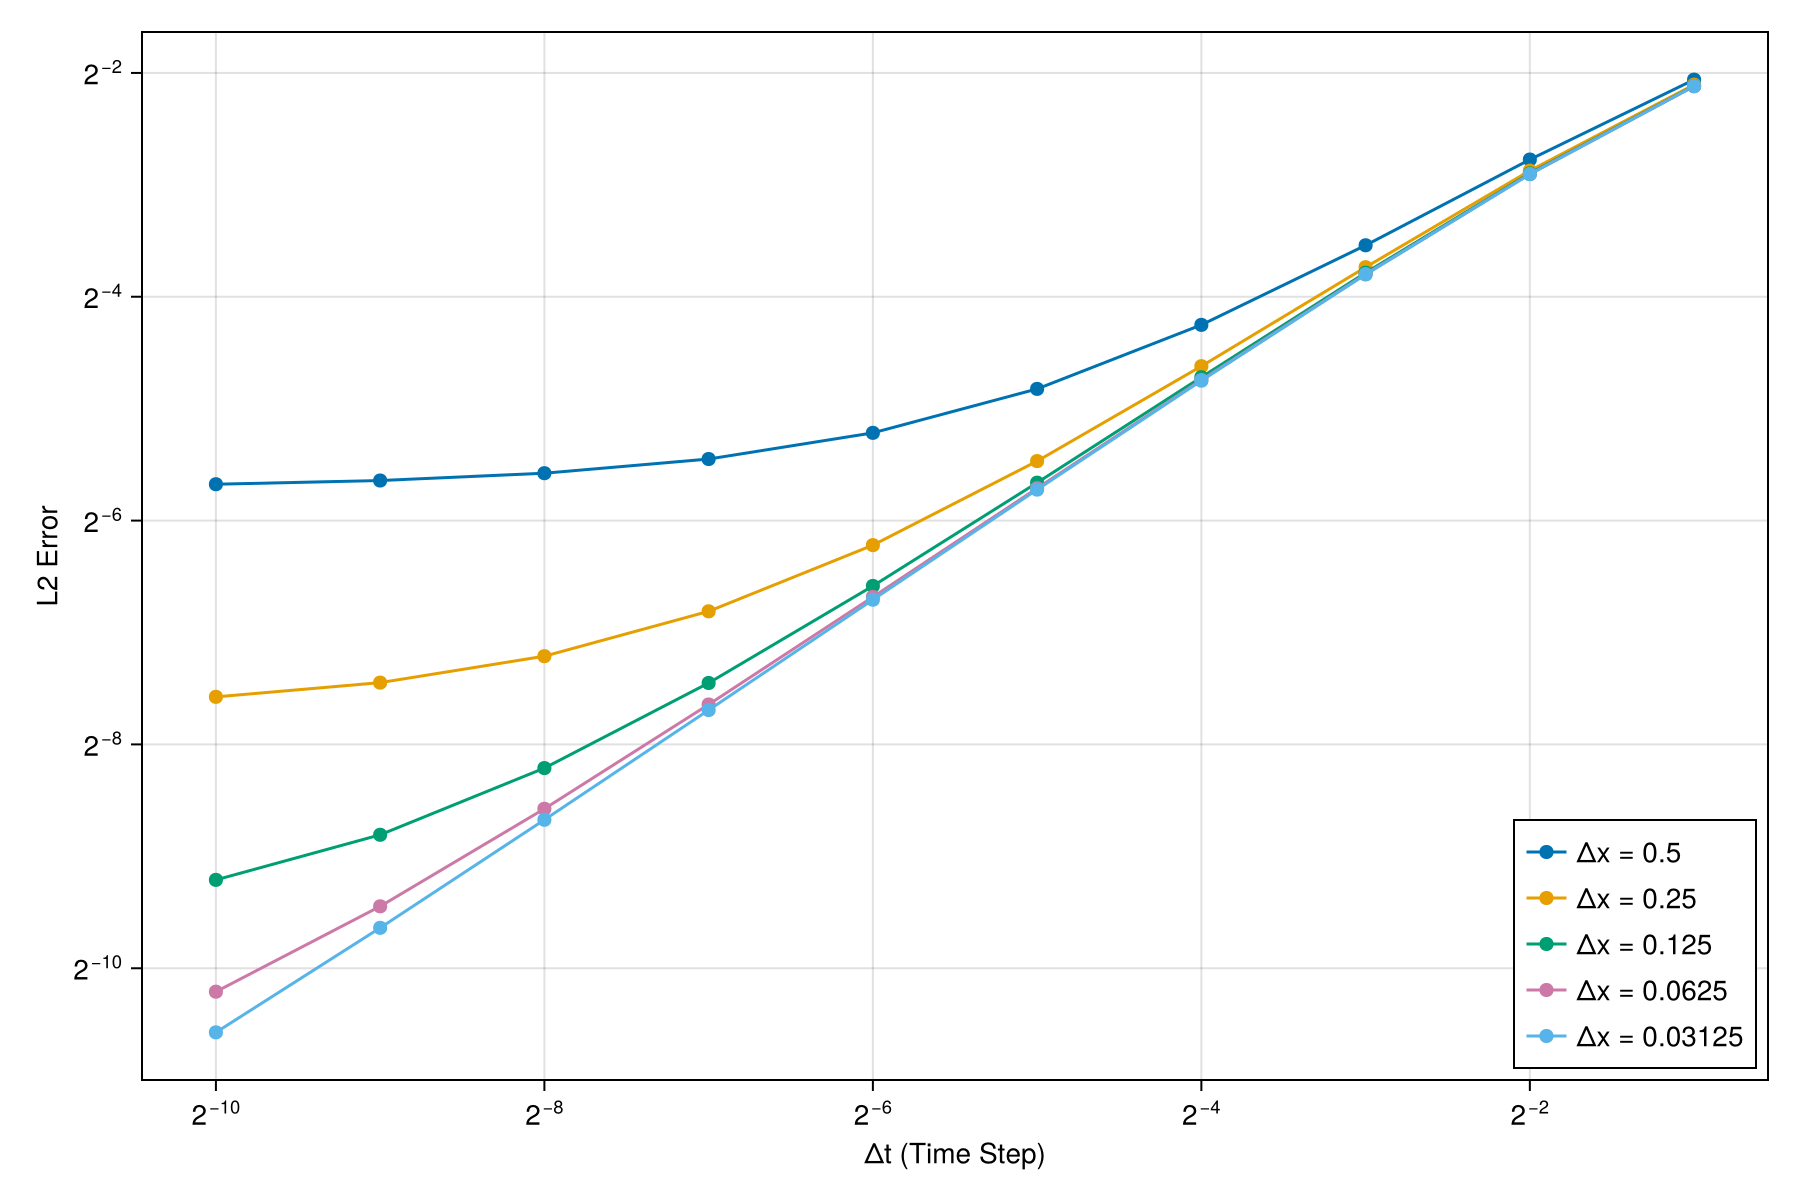

CairoMakie.Screen{IMAGE}


In [7]:
# --- Plotting ---
fig = CairoMakie.Figure(size = (900, 600))
ax = Axis(fig[1, 1];
    xscale = Makie.log2,
    yscale = Makie.log2,
    xlabel = "Δt (Time Step)",
    ylabel = "L2 Error"#,
    # title = "Time Convergence for Various Spatial Resolutions"
)

ax.xgridvisible = true
ax.ygridvisible = true

colors = Makie.wong_colors()

for (i, partn) in enumerate(partns)
    errs = errors_dict[partn]
    Δx= 1/partn
    CairoMakie.scatterlines!(ax, dts, errs;
        markersize = 10,
        label = "Δx = $Δx",
        color = colors[i]
    )
end

CairoMakie.axislegend(ax; position=:rb)
CairoMakie.display(fig)


In [8]:
CairoMakie.save("convergence_plot.png", fig)


CairoMakie.Screen{IMAGE}


In [9]:
# # Definer tidsstegene og løsningen
# T = [(t0, T0)]  # Start med initialbetingelsen
# for (t, TT) in zip(timesteps, computed_solutions)
#     push!(T, (t, FEFunction(Trialspace, copy(get_free_dof_values(TT)))))
# end

# # Lagre løsningene som VTK-filer og lag PVD-filen
# if !isdir("tmp_M")
#     mkdir("tmp_M")
# end

# createpvd("results_M") do pvd
#     # Lagre den initiale løsningen ved t = t0
#     pvd[0] = createvtk(Ω, "tmp_M/results_0.vtu", cellfields=["T" => T0])
    
#     # Lagre løsningene for hvert tidssteg
#     for (tn, (t, TT)) in enumerate(T)
#         # Hent FE-funksjonen for løsningen ved tidssteg t
#         Tn = FEFunction(Trialspace, copy(get_free_dof_values(TT)))
        
#         # Lagre løsningen som en VTK-fil
#         pvd[tn] = createvtk(Ω, "tmp_M/results_$tn.vtu", cellfields=["T" => Tn])
#     end
# end



First we want to solve the (SE) for given data.

In $\Omega=(0,1)^2$ we use $T(x,y,t)=\sin(\pi x)\sin(\pi y)\cos(\pi^2t)$ we look at our problem
$\begin{align}
&\min E(Q,T)=\frac12\int_{t_0}^{t_F}\int_\Omega p^2(t)(Q(x,t)-Q_d(x,t))^2\,\mathrm{d}x\mathrm dt+\frac\gamma2\int_\Omega |T(x,t_F)-T_\text{fin}(x)|^2\mathrm dx \\
&\begin{cases}
\rho c\dot T(x,t)&=\nabla\cdot\left(k(x)\nabla T(x,t)\right)+Q(x,t) && \text{in}\ \Omega\times(0,t_F) \\
-k(x)\partial_\nu T(x,t)&=h(x)\left(T(x,t)-T_\text{out}(x,t)\right) && \text{on}\ \partial\Omega\times[0,t_F]\\
T(x,0)=T_\text{ini}(x)&
\end{cases}\tag{SE}
\end{align}$
here specifically with $ρ≡c≡k≡h≡1$. So we want to solve
$\begin{align}
&\begin{cases}
\dot T(x,t)&=\Delta T(x,t)+Q(x,t) && \text{in}\ \Omega\times(0,t_F) \\
-\partial_\nu T(x,t)&=\left(T(x,t)-T_\text{out}(x,t)\right) && \text{on}\ \partial\Omega\times[0,t_F]\\
T(x,0)=T_\text{ini}(x)&
\end{cases}\tag{SE}
\end{align}$
We compute
$\begin{align}
\dot T(x,y,t)&=-\pi^2\sin(\pi x)\sin(\pi y)\sin(\pi^2t)\\
∂_{1}T(x,y,t)&=\pi\cos(\pi x)\sin(\pi y)\cos(\pi^2t)\\
∂_{2}T(x,y,t)&=\pi\sin(\pi x)\cos(\pi y)\cos(\pi^2t)\\
∂_{11}T(x,y,t)&=-\pi^2\sin(\pi x)\sin(\pi y)\cos(\pi^2t)\\
∂_{22}T(x,y,t)&=-\pi^2\sin(\pi x)\sin(\pi y)\cos(\pi^2t)\\
\Delta T(x,y,t)&=-2\pi^2\sin(\pi x)\sin(\pi y)\cos(\pi^2t)\\
\partial_\nu T(x,y,t)&=\begin{cases}
-∂_{2}T(x,y,t)&=-\pi\sin(\pi x)\cos(\pi^2t)&&\text{on}\ (0,1)\times\{0\} \\
∂_{1}T(x,y,t)&=-\pi\sin(\pi y)\cos(\pi^2t)&&\text{on}\ \{1\}\times(0,1) \\
∂_{2}T(x,y,t)&=-\pi\sin(\pi x)\cos(\pi^2t)&&\text{on}\ (0,1)\times\{1\} \\
-∂_{1}T(x,y,t)&=-\pi\sin(\pi y)\cos(\pi^2t)&&\text{on}\ \{0\}\times(0,1)
\end{cases}
\end{align}$
giving us
$\begin{align}
Q(x,y,t)&=\pi^2\sin(\pi x)\sin(\pi y)\left(-\rho(x,y)c(x,y)\sin(\pi^2t)+2k(x,y)\cos(\pi^2t)\right) \\
T_\text{out}(x,t)&=T(x,t)+\partial_\nu T(x,t)
\end{align}$

Now we use these $T$ and $Q$ for the (CP). We set $Q_d=Q$ and $T_\text{fin}(x,y)=T(x,y,t_F)$ and as gradient get $∇e=p^2(t)(Q(x,y,t)-Q_d(x,y,t))-W(x,y,t)$. As initial guess we use $Q_0=\pi^2$.

But first we want to check the AEsolver on its own. The (AE) stays the same, namely
$\begin{align}
\int\limits_0^{t_F}\int\limits_\Omega \rho c\psi(x,t)\dot W(x,t)-k(x)\nabla \psi(x,t)\cdot\nabla W(x,t)\,\mathrm dx\mathrm dt-\int\limits_0^{t_F}\int\limits_{\partial\Omega} h(y)\psi(y,t)W(y,t)\,\mathrm dy\mathrm dt=0 \tag{WAE}
\end{align}$
In order to get the solution $W$ for our test case we look at the Lagrangian
$$L(Q,T,W)=\frac12\int\limits_{t_0}^{t_F}\int\limits_\Omega p^2(t)(Q(x,t)-Q_d(x,t))^2\,\mathrm{d}x\mathrm dt+\frac\gamma2\int\limits_\Omega |T(x,t_F)-T_\text{fin}(x)|^2\mathrm dx+\int\limits_{t_0}^{t_F}\int\limits_\Omega \rho c\dot T(x,t)W(x,t)+k(x)\nabla T(x,t)\cdot \nabla W(x,t)-Q(x,t)W(x,t)\,\mathrm dx\mathrm dt+\int\limits_{t_0}^{t_F}\int\limits_{\partial\Omega}h(x)(T(y,t)-T_\text{out}(y,t))W(y,t) \,\mathrm dy\mathrm dt$$
and just to show that the (AE) stays the same look at the $T$-derivative
$\begin{align}
L_T(Q,T,W)\psi&=\gamma\int\limits_\Omega (T(x,t_F)-T_\text{fin}(x))\psi(x,t_F)\mathrm dx+\int\limits_{t_0}^{t_F}\int\limits_\Omega \rho c\dot \psi(x,t)W(x,t)+k(x)\nabla \psi(x,t)\cdot \nabla W(x,t)\,\mathrm dx\mathrm dt+\int\limits_{t_0}^{t_F}\int\limits_{\partial\Omega}h(x)\psi(y,t)W(y,t) \,\mathrm dy\mathrm dt \\
&=\int\limits_\Omega \gamma(T(x,t_F)-T_\text{fin}(x))\psi(x,t_F)+\rho c W(x,t_F)\psi(x,t_F)\mathrm dx+\int\limits_{t_0}^{t_F}\int\limits_\Omega -\rho c\dot W(x,t)\psi(x,t)+k(x)\nabla \psi(x,t)\cdot \nabla W(x,t)\,\mathrm dx\mathrm dt+\int\limits_{t_0}^{t_F}\int\limits_{\partial\Omega}h(x)\psi(y,t)W(y,t) \,\mathrm dy\mathrm dt \tag{WAE}\\
&=\int\limits_\Omega \gamma(T(x,t_F)-T_\text{fin}(x))\psi(x,t_F)+\rho c W(x,t_F)\psi(x,t_F)\mathrm dx+\int\limits_{t_0}^{t_F}\int\limits_\Omega -\rho c\dot W(x,t)\psi(x,t)-\nabla\cdot(k(x)\nabla W(x,t)) \psi(x,t)\,\mathrm dx\mathrm dt+\int\limits_{t_0}^{t_F}\int\limits_{\partial\Omega}(h(x)W(y,t)+k(y)\partial_\nu W(y,t))\psi(y,t) \,\mathrm dy\mathrm dt
\end{align}$
confirming the (WAE) and giving the strong version (AE) as known
$\begin{align}
\begin{cases}
\rho c\dot W(x,t)&=-\nabla\cdot\left(k(x)\nabla W(x,t)\right)&&\text{in}\ \Omega\times(0,t_F) \\
k(y)\partial_\nu W(y,t)&=-h(y)W(y,t)&&\text{on}\ \partial\Omega\times[0,t_F] \\
W(x,t_F)&=-\frac{\gamma}{\rho c}\left(T(x,t_F)-T_\text{fin}(x)\right)&&\text{in}\ \Omega
\end{cases}\tag{AE}
\end{align}$
With the transform $\widetilde W(x,t)=W(x,t_F-t)$ we get
$\begin{align}
\begin{cases}
\rho c\dot W(x,t)&=\nabla\cdot\left(k(x)\nabla W(x,t)\right)&&\text{in}\ \Omega\times(0,t_F) \\
k(y)\partial_\nu W(y,t)&=-h(y)W(y,t)&&\text{on}\ \partial\Omega\times[0,t_F] \\
W(x,0)&=-\frac{\gamma}{\rho c}\left(T(x,t_F)-T_\text{fin}(x)\right)&&\text{in}\ \Omega
\end{cases}\tag{AE}
\end{align}$
with the weak form
$\begin{align}
\int\limits_{t_0}^{t_F}\int\limits_\Omega \rho c\dot W(x,t)\psi(x,t)+k(x)\nabla \psi(x,t)\cdot \nabla W(x,t)\,\mathrm dx\mathrm dt+\int\limits_{t_0}^{t_F}\int\limits_{\partial\Omega}h(x)\psi(y,t)W(y,t) \,\mathrm dy\mathrm dt=0 \tag{WAE}
\end{align}$
Now we use the necessary condition $L_Q=0$ to compute the solution $W$ for our data.
$$L_Q(Q,T,W)h=\int\limits_{t_0}^{t_F}\int\limits_\Omega p^2(t)(Q(x,t)-Q_d(x,t))h(x,t)\,\mathrm{d}x\mathrm dt-\int\limits_{t_0}^{t_F}\int\limits_\Omega h(x,t)W(x,t)\,\mathrm dx\mathrm dt\hat=p^2(t)(Q(x,t)-Q_d(x,t))-W(x,t)$$
which for our data gives the solution $W\equiv0$ (as expected since the data represents the solution to the minimisation problem).